In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
from scipy import stats
import numpy as np
import scipy.sparse as sparse
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import call
from sklearn.metrics import mean_squared_error
df = pd.read_csv("C:/Users/Carla/Documents/Untitled Folder/AMLAS/ml-latest-small/ml-latest-small/ratings.csv")
from math import sqrt
from tqdm import tqdm
movieList = pd.read_csv("C:/Users/Carla/Documents/Untitled Folder/AMLAS/ml-latest-small/ml-latest-small/movies.csv")
movieTags = pd.read_csv("C:/Users/Carla/Documents/Untitled Folder/AMLAS/ml-latest-small/ml-latest-small/tags.csv")

In [2]:
uniqueMovies = df["movieId"].unique()


In [3]:
data = np.zeros((uniqueMovies.shape[0],2))

for i in range(uniqueMovies.shape[0]):
    data[i,0] = int(i)
    data[i,1] = uniqueMovies[i]
    
    
movieData = pd.DataFrame(data, columns = ['newId', 'movieId'])
movieData

def MovieIndx(df,id):
    x = df.loc[df["movieId"] == id]
    y = x.iat[0,0]
    return y

def queryUser(df,id):
    
    return df.loc[df["userId"] == id]


def queryMovie(df,id):
    
    
    return df.loc[df["movieId"] == id]

def revMovieIndx(df,id):
    x = df.loc[df["newId"] == id]
    y = x.iat[0,1]

    return y



In [4]:
def checkPref(df,userId,movieList):
    
    userList = df[df.userId == userId]
    sortedList = userList.sort_values("rating")
    topFive = sortedList.tail(10)
    recList = []
    
    
    for row in topFive.itertuples(index = False):
        
        
        
            movieName = getMovieName(row.movieId,movieList)
            movieGenres = movieList.genres[movieList.movieId == row.movieId]
            movieSum = [movieName ,movieGenres]
            recList = np.append(recList,movieSum)
        
    return recList
    
    
    

In [5]:
def printMovies(Mlist):
  
    print("movie recommendations:")
    print("-------------------------")
  
    for i in range(len(Mlist)):
        if i%2 ==0:
            print("movieName: ", Mlist[i])
        
        else:
            print("movieGenres: " , Mlist[i])
            print('\n')
    print('\n')
    

In [6]:
def createNewUsers(userId,movieId,rating,versionId):
    
    from csv import writer
    with open('newRatings.csv', 'a',newline='') as f_object:  
    
        data = [userId,movieId,rating,versionId]
        
        writer_object = writer(f_object)
    
        writer_object.writerow(data)  
    
        f_object.close()
  

def logUserFeedback(userId,movieId,rating,versionId):
    
    from csv import writer
    with open('userFeedback.csv', 'a',newline='') as f_object:  
        
        data = np.zeros((len(userId),4))
        
        data[:,0] = userId
        data[:,1] = movieId
        data[:,2] = rating
        data[:,3] = versionId
        
        
        writer_object = writer(f_object)
    
    
        writer_object.writerows(data)  
    
        f_object.close()

In [7]:
## create 100 new dummy users

header = ['userId', 'movieId', 'rating','versionId']

with open('newRatings.csv', 'w', encoding='UTF8',newline = '') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)
newUsers = df[df.userId <=100]

for row in newUsers.itertuples(index = False):
    
    if row.userId % 2 == 0:
        
        createNewUsers(row.userId,row.movieId,row.rating,1)
        
    if row.userId %2 !=0:
        
        createNewUsers(row.userId,row.movieId,row.rating,2)
        

   
    
    



In [8]:
newMovieData = pd.read_csv("C:/Users/Carla/Documents/Untitled Folder/newRatings.csv")

data = np.zeros((100,2))
users = newMovieData["userId"].unique()

for i in range(100):
    data[i,0] = int(i)
    data[i,1] = users[i]
    
     
    
userData = pd.DataFrame(data, columns = ['newId', 'userId'])


def userIndex(df,id):
    x = df.loc[df["userId"] == id]
    y = x.iat[0,0]
    return y

def revUserIndx(df,id):
    x = df.loc[df["newId"] == id]
    y = x.iat[0,1]

    return y

def getMovieName(movieId,df):
    x = df.loc[df["movieId"] == movieId]
    
    return x.title
    

data = np.zeros((len(newMovieData["movieId"].unique()),2))

uniqueMovies = newMovieData["movieId"].unique()

for i in range(len(newMovieData["movieId"].unique())):
    data[i,0] = int(i)
    data[i,1] = uniqueMovies[i]
    
newMovies = pd.DataFrame(data, columns = ['newId', 'movieId'])


In [9]:
dataVersion1 = newMovieData[newMovieData.versionId == 1]
dataVersion2 = newMovieData[newMovieData.versionId == 2]

In [10]:
def fit(train,n_factors,n_iters,movieData,userData):
    
    
 
    lambda_1 = 1
    tau = 0.05
    
    n_users, n_movies = len(train["userId"].unique()),len(train["movieId"].unique())
    user_factors = np.random.normal(0,sqrt(lambda_1),size = (n_factors,n_users))
    movie_factors = np.random.normal(0,sqrt(lambda_1),size = (n_factors,n_movies))
    
    user_bias = np.zeros(n_users)
    movie_bias = np.zeros(n_movies)
    
    mse_record = []
    
    its = 0
    
    for i in range(n_iters):
        
        user_factors, user_bias = updateUsers(train,movie_factors,movie_bias, user_factors,lambda_1,tau,movieData,userData)
        movie_factors, movie_bias = updateMovies(train,user_factors,user_bias,movie_factors,lambda_1,tau,movieData,userData)
        

        train_mse = error(train,user_factors,movie_factors,user_bias,movie_bias,movieData,userData)
        mse_record = np.append(mse_record,train_mse)
        its = its + 1


    return mse_record,user_factors,movie_factors,user_bias,movie_bias

def updateUsers(df,movie_factors,movie_bias, user_factors,lmda,tau,movieData,userDataV):
    
    
    I = np.eye(user_factors.shape[0]+1)
    I[-1,-1] = 0.0001
    
    ones = np.ones((1,movie_factors.shape[1]))
  

    y = movie_factors
    y = np.vstack((y,np.atleast_2d(ones)))

    
    z = np.zeros((user_factors.shape[0]+1,user_factors.shape[1]))

    # Loop over all users
    
    for i in range(user_factors.shape[1]):
        H = tau/lmda*I
        
        userIndex = int(revUserIndx(userDataV,i))
       
            
            
        userData = queryUser(df, userIndex)
        new_user = False
        sum = 0
        for row in userData.itertuples(index = False):
            
            index = int(MovieIndx(movieData,row.movieId))
            if new_user == False:
            
                y_user = y[:,index].reshape((movie_factors.shape[0]+1,1))
                new_user = True
            y_user = np.hstack((y_user,y[:,index].reshape((movie_factors.shape[0]+1,1))))
            x = row.rating - movie_bias[index]
            sum = sum + x*y[:,index]
    
        H = y_user@y_user.T + H
        H_inv = np.linalg.inv(H)
        b = sum 
        new_vec = H_inv@b
        z[:,i] = new_vec
    
    
    user_factors = z[0:z.shape[0]-1,:]
    user_bias = z[z.shape[0]-1,:]    

    return user_factors,user_bias   

def updateMovies(df,user_factors,user_bias, movie_factors,lmda,tau,movieData,userDataV):
    
    
    I = np.eye(user_factors.shape[0]+1)
    I[-1,-1] = 0.0001
    
    ones = np.ones((1,user_factors.shape[1]))
  

    y = user_factors
    y = np.vstack((y,np.atleast_2d(ones)))

    
    z = np.zeros((movie_factors.shape[0]+1,movie_factors.shape[1]))

    # Loop over all users
    
    for i in range(movie_factors.shape[1]):
        H = tau/lmda*I
        movie_ind = revMovieIndx(movieData,i)
        movie_data = queryMovie(df, movie_ind)
        new_movie = False
        sum = 0
        for row in movie_data.itertuples(index = False):
            
            
            index = int(userIndex(userDataV,row.userId))
            
            if new_movie == False:
            
                y_movie = y[:,index].reshape((movie_factors.shape[0]+1,1))
                new_movie = True
            y_movie = np.hstack((y_movie,y[:,index].reshape((movie_factors.shape[0]+1,1))))
            x = row.rating - user_bias[index]
            sum = sum + x*y[:,index]
    
        H = y_movie@y_movie.T + H
        H_inv = np.linalg.inv(H)
        b = sum 
        new_vec = H_inv@b
        z[:,i] = new_vec
    
    
    movie_factors = z[0:z.shape[0]-1,:]
    movie_bias = z[z.shape[0]-1,:]    

    return movie_factors,movie_bias  

def error(df,user_factors,movie_factors,user_bias,movie_bias,movieData,userDataV):
    
    error =0
    c = 0
    for row in df.itertuples(index = False):
        
        y_true = row.rating
        user = int(userIndex(userDataV,row.userId))
        movie = int(MovieIndx(movieData,row.movieId))
      
        
        y_pred = user_factors[:,user].T@movie_factors[:,movie] + movie_bias[movie] + user_bias[user]
        
        error = error + (y_true - y_pred)**2
        c = c +1
    rmse = sqrt((1/c)*error)
    
    return rmse


def createreco_ABtest(userId,user_factors,movie_factors,df,movieData,movieList,movie_bias,user_bias,userData,versionId):

    
    userInd = int(userIndex(userData,userId))
    movieIds = np.zeros(8)
     

    
    if versionId == 1:
        
        list = user_factors[:,userInd].T@movie_factors
        list = np.reshape(list,(1,movie_factors.shape[1]))
        list = list  + user_bias[userInd] 
        
        for i in range(movie_factors.shape[1]):
        
            list[0,i] = list[0,i] + movie_bias[i]
        

        userList = df[df.userId == userId]  

        for row in userList.itertuples(index=False):
            index = int(MovieIndx(movieData,row.movieId))
            list[0,index] = 0
  
        sort_index = np.argsort(list)
        topFive = sort_index[0,-8:]
        recList = []
        for i in range(len(topFive)):
            ind = int(topFive[i])
            x = revMovieIndx(movieData,ind)
        
            movieIds[i] = x
            movieName = getMovieName(x,movieList)
            movieGenres = movieList.genres[movieList.movieId == x]
            movieSum = [movieName ,movieGenres]
            recList = np.append(recList,movieSum)
            
            
    if versionId == 2:
        
        list = user_factors[:,userInd].T@movie_factors
        list = np.reshape(list,(1,movie_factors.shape[1]))
        list = list  + 0.95*user_bias[userInd]
    
        for i in range(movie_factors.shape[1]):
        
            list[0,i] = list[0,i] + 0.05*movie_bias[i]
        

        userList = df[df.userId == userId]  

        for row in userList.itertuples(index=False):
            index = int(MovieIndx(movieData,row.movieId))
            list[0,index] = 0
        
        sort_index = np.argsort(list)
        topFive = sort_index[0,-8:]
        recList = []
        for i in range(len(topFive)):
            ind = int(topFive[i])
            x = revMovieIndx(movieData,ind)
        
            movieIds[i] = x
            movieName = getMovieName(x,movieList)
            movieGenres = movieList.genres[movieList.movieId == x]
            movieSum = [movieName ,movieGenres]
            recList = np.append(recList,movieSum)
        
       
    return recList,movieIds

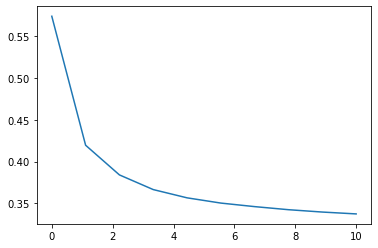

In [11]:
mse,uf,mf,ub,mb = fit(newMovieData,10,10,movieData,userData)

x =np.linspace(0,10,10)
plt.plot(x,mse)


In [12]:
r,ids = createreco_ABtest(10,uf,mf,newMovieData,newMovies,movieList,mb,ub,userData,1)
r2,ids2 = createreco_ABtest(10,uf,mf,newMovieData,newMovies,movieList,mb,ub,userData,2)
print(ids)
print(ids2)

[  2617.   6874.    736.    353.   7438. 106487.  91500.   1732.]
[  2985.   6874.    736.   7438.    256. 106487.  91500.   1732.]


In [13]:
##simulate feedback on movies


newRatings = pd.read_csv("C:/Users/Carla/Documents/Untitled Folder/newRatings.csv")
users = newRatings["userId"].unique()
movies = np.zeros(100 * 8)
ratings = np.zeros(100 * 8)
versionIds = np.zeros(100 * 8)
userList = np.zeros(100*8)
j = 0

sampleRange = np.array([0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
weights = np.random.dirichlet(np.ones(11),size=1)

for i in range(len(users)):
    
    if i %2 == 0: 
        versionId = 1
        
    if i%2 !=0:
        versionId = 2
     
    recs,ids = createreco_ABtest(i+1,uf,mf,newMovieData,newMovies,movieList,mb,ub,userData,versionId)
    
    for k in range(8):
        userList[j+k] = users[i]
        versionIds[j+k] = versionId
        if versionId == 1:
            x = random.choices(sampleRange,k = 1)
            r = float(x[0])
            ratings[j+k] = r
            
        if versionId == 2:
            x = random.choices(sampleRange,weights = [1,2,1,3,5,5,1,2,4,4],k =1)
            r = float(x[0])
            ratings[j+k] = r
        movies[j+k] = ids[k]
        
    j = j+8
        
    
   
        
    
        



    




IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
header = ['userId', 'movieId', 'rating',"versionId"]

data = [[users,movies,ratings,versionIds]]

with open('userFeedback.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)
    
logUserFeedback(userList,movies,ratings,versionIds)
    

In [ ]:
ud = pd.read_csv("C:/Users/Carla/Documents/Untitled Folder/userFeedback.csv")


In [ ]:
## extract the version ratings

version1Ratings = ud[ud.versionId == 1]

version2Ratings = ud[ud.versionId == 2]

version1Ratings.to_csv("version1Ratings.csv")
version2Ratings.to_csv("version2Ratings.csv")

In [ ]:
ratings1 =  version1Ratings.iloc[:,[2]]
ratings2 =  version2Ratings.iloc[:,[2]]

ratings1 = np.array(ratings1.rating)
ratings2 = np.array(ratings2.rating)

t_value,p_value=stats.ttest_ind(ratings1,ratings2,alternative = "less")

print('Test statistic is %f'%float("{:.6f}".format(t_value)))

print('p-value for two tailed test is %f'%p_value)

alpha = 0.05

if p_value<=alpha:

    print('Conclusion','n','Since p-value(=%f)'%p_value,'<','alpha(=%.2f)'%alpha,'''We reject the null hypothesis H0. So we conclude that the 

effect of version 1 recommender and version 2 recommender on users are not equal i.e., μ1 = μ2 at %.2f level of significance.'''%alpha)

else:

    print('Conclusion','n','Since p-value(=%f)'%p_value,'>','alpha(=%.2f)'%alpha,'We do not reject the null hypothesis H0.')